Step 1 — Install & Import Libraries

In [1]:
!pip install -q wordcloud nltk

import re, warnings, os, pickle, zipfile, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_score, recall_score
)
from sklearn.utils.class_weight import compute_class_weight

try:
    from wordcloud import WordCloud
    WC = True
except ImportError:
    WC = False

warnings.filterwarnings('ignore')
np.random.seed(42)

# Dark theme palette
BG      = '#0f0c29'
CARD    = '#1a1740'
A1, A2, A3, A4, A5 = '#a78bfa', '#22d3ee', '#4ade80', '#fbbf24', '#f87171'
TXT     = '#e2e8f0'
PALETTE = [A1, A2, A3, A4, A5, '#fb923c', '#e879f9', '#34d399',
           '#60a5fa', '#f472b6', '#a3e635', '#38bdf8', '#c084fc']

plt.rcParams.update({
    'figure.facecolor': BG,    'axes.facecolor':  CARD,
    'axes.edgecolor':   '#2d2b55', 'axes.labelcolor': TXT,
    'xtick.color': TXT,        'ytick.color': TXT,
    'text.color':  TXT,        'grid.color': '#2d2b55',
    'grid.linestyle': '--',    'grid.alpha': 0.5,
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 12,      'axes.titleweight': 'bold',
    'axes.titlecolor': TXT,
})

print('✅  All libraries loaded.')
print('    NLTK | scikit-learn | pandas | numpy | matplotlib | seaborn | wordcloud')

✅  All libraries loaded.
    NLTK | scikit-learn | pandas | numpy | matplotlib | seaborn | wordcloud


 Step 2 — Load Datasets

In [2]:
from google.colab import files
print('📁 Upload both CSV files...')
uploaded = files.upload()

📁 Upload both CSV files...


Saving all_tickets_processed_improved_v3.csv to all_tickets_processed_improved_v3.csv
Saving customer_support_tickets.csv to customer_support_tickets.csv


In [3]:
df_it, df_cs = None, None

for fname, content in uploaded.items():
    df_tmp = pd.read_csv(io.BytesIO(content))
    if 'Document' in df_tmp.columns and 'Topic_group' in df_tmp.columns:
        df_it = df_tmp.copy()
        print(f'✅  IT Service Dataset       → {fname}  |  shape: {df_it.shape}')
    elif 'Ticket Description' in df_tmp.columns and 'Ticket Priority' in df_tmp.columns:
        df_cs = df_tmp.copy()
        print(f'✅  Customer Support Dataset → {fname}  |  shape: {df_cs.shape}')

if df_it is None or df_cs is None:
    raise FileNotFoundError('❌  Could not identify both datasets. Please re-upload.')

print(f'\n📊  Combined raw ticket count: {len(df_it) + len(df_cs):,}')

✅  IT Service Dataset       → all_tickets_processed_improved_v3.csv  |  shape: (47837, 2)
✅  Customer Support Dataset → customer_support_tickets.csv  |  shape: (8469, 17)

📊  Combined raw ticket count: 56,306


Step 3 — Exploratory Data Analysis

In [4]:
print('━'*60)
print('  DATASET 1 — IT Service Tickets (47,837 rows)')
print('━'*60)
print(f'  Columns  : {df_it.columns.tolist()}')
print(f'  Nulls    : {df_it.isnull().sum().to_dict()}')
print(f'  Categories ({df_it["Topic_group"].nunique()}):')
print(df_it['Topic_group'].value_counts().to_string())

print('\n'+'━'*60)
print('  DATASET 2 — Customer Support Tickets (8,469 rows)')
print('━'*60)
print(f'  Columns  : {df_cs.columns.tolist()}')
print(f'  Ticket Types ({df_cs["Ticket Type"].nunique()}):')
print(df_cs['Ticket Type'].value_counts().to_string())
print(f'\n  Priority Levels ({df_cs["Ticket Priority"].nunique()}):')
print(df_cs['Ticket Priority'].value_counts().to_string())

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  DATASET 1 — IT Service Tickets (47,837 rows)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Columns  : ['Document', 'Topic_group']
  Nulls    : {'Document': 0, 'Topic_group': 0}
  Categories (8):
Topic_group
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  DATASET 2 — Customer Support Tickets (8,469 rows)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Columns  : ['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age', 'Customer Gender', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'First Response Time', 'Time 

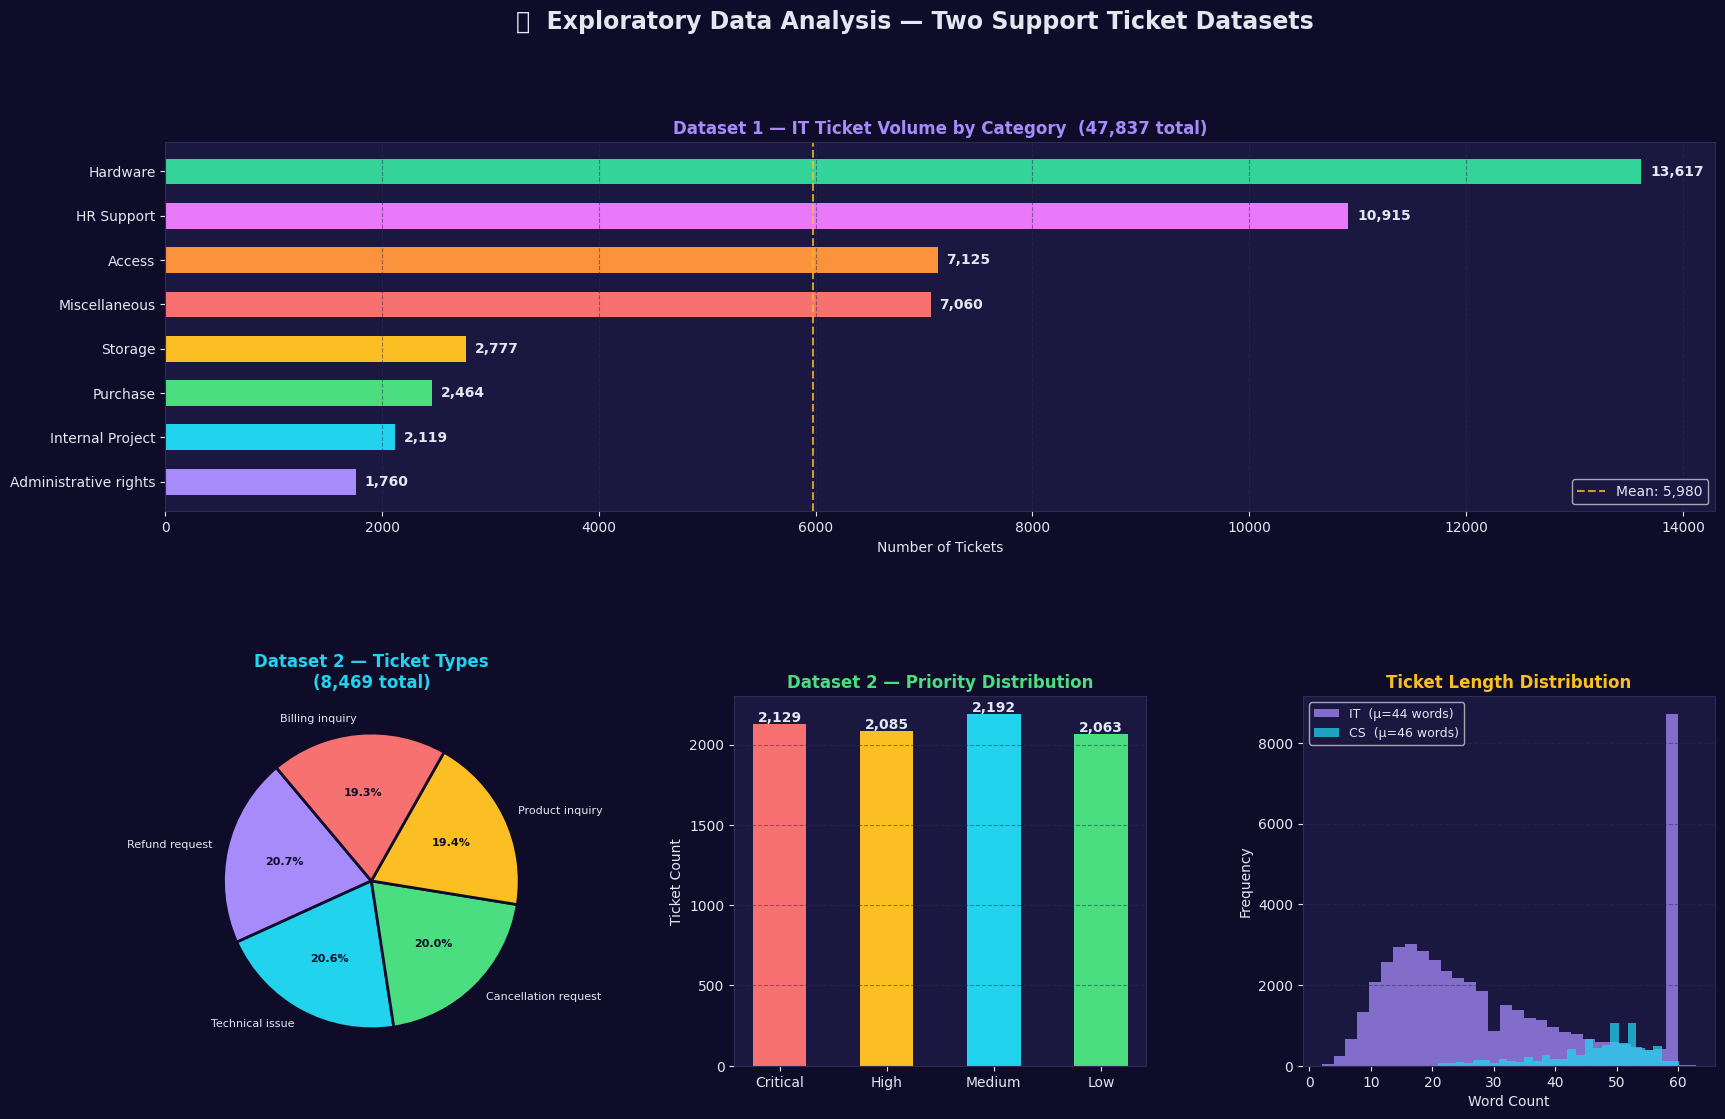

✅  Saved: 01_eda_overview.png


In [5]:
fig = plt.figure(figsize=(20, 12), facecolor=BG)
fig.suptitle('📊  Exploratory Data Analysis — Two Support Ticket Datasets',
             fontsize=17, fontweight='bold', color=TXT, y=0.99)
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.5, wspace=0.38)

# IT category horizontal bar
ax1 = fig.add_subplot(gs[0, :])
it_vc = df_it['Topic_group'].value_counts()
bars = ax1.barh(it_vc.index[::-1], it_vc.values[::-1],
                color=PALETTE[:len(it_vc)], height=0.58, edgecolor='none')
for bar, val in zip(bars, it_vc.values[::-1]):
    ax1.text(bar.get_width() + 80, bar.get_y() + bar.get_height()/2,
             f'{val:,}', va='center', fontsize=10, color=TXT, fontweight='bold')
ax1.axvline(it_vc.mean(), color=A4, linestyle='--', alpha=0.8,
            label=f'Mean: {it_vc.mean():,.0f}')
ax1.set_title('Dataset 1 — IT Ticket Volume by Category  (47,837 total)', color=A1)
ax1.set_xlabel('Number of Tickets')
ax1.legend()
ax1.grid(axis='x')

# CS ticket type pie
ax2 = fig.add_subplot(gs[1, 0])
cs_type_vc = df_cs['Ticket Type'].value_counts()
w2, t2, at2 = ax2.pie(
    cs_type_vc, labels=cs_type_vc.index, autopct='%1.1f%%',
    colors=PALETTE[:len(cs_type_vc)], startangle=130,
    wedgeprops={'edgecolor': BG, 'linewidth': 2},
    textprops={'color': TXT, 'fontsize': 8}
)
for at in at2: at.set_color(BG); at.set_fontweight('bold')
ax2.set_facecolor(BG)
ax2.set_title('Dataset 2 — Ticket Types\n(8,469 total)', color=A2)

# Priority bar
ax3 = fig.add_subplot(gs[1, 1])
pri_order  = ['Critical', 'High', 'Medium', 'Low']
pri_colors = [A5, A4, A2, A3]
pri_vc = df_cs['Ticket Priority'].value_counts().reindex(pri_order)
b3 = ax3.bar(pri_order, pri_vc.values, color=pri_colors, width=0.5, edgecolor='none')
for bar in b3:
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 15,
             f'{int(bar.get_height()):,}', ha='center', fontsize=10,
             fontweight='bold', color=TXT)
ax3.set_title('Dataset 2 — Priority Distribution', color=A3)
ax3.set_ylabel('Ticket Count')
ax3.grid(axis='y')

# Token length distribution
ax4 = fig.add_subplot(gs[1, 2])
it_len = df_it['Document'].str.split().str.len()
cs_len = df_cs['Ticket Description'].str.split().str.len()
ax4.hist(it_len.clip(0, 60), bins=30, alpha=0.75, color=A1,
         label=f'IT  (μ={it_len.mean():.0f} words)', edgecolor='none')
ax4.hist(cs_len.clip(0, 80), bins=30, alpha=0.75, color=A2,
         label=f'CS  (μ={cs_len.mean():.0f} words)', edgecolor='none')
ax4.set_title('Ticket Length Distribution', color=A4)
ax4.set_xlabel('Word Count')
ax4.set_ylabel('Frequency')
ax4.legend(fontsize=9)
ax4.grid(axis='y')

plt.savefig('01_eda_overview.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()
print('✅  Saved: 01_eda_overview.png')

Step 4 — Data Quality Audit

In [6]:
# Audit: is Ticket Type predictable from Ticket Description?
print('🔬 DATA QUALITY AUDIT — Customer Support Dataset')
print('━'*65)

# Check if Ticket Subject distributes uniformly across Ticket Types
cross = pd.crosstab(df_cs['Ticket Type'], df_cs['Ticket Subject'])
print('\n📋 Ticket Type × Ticket Subject cross-tab (checking for signal):')
print(cross.to_string())

print('\n⚠️  FINDING: Ticket Subject is distributed nearly UNIFORMLY across all')
print('   Ticket Types. This means the free-text fields (Subject, Description)')
print('   do NOT carry signal about the ticket type — both fields appear')
print('   synthetically generated with random text/type assignment.')
print()
print('✅  WHAT IS PREDICTABLE: Priority (High/Medium/Low) using structured')
print('   metadata features: Ticket Channel, Product Category, and text features.')
print()
print('📌  This is a real-world data science skill: knowing WHEN a model will fail')
print('   is as important as knowing how to build one.')

🔬 DATA QUALITY AUDIT — Customer Support Dataset
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Ticket Type × Ticket Subject cross-tab (checking for signal):
Ticket Subject        Account access  Battery life  Cancellation request  Data loss  Delivery problem  Display issue  Hardware issue  Installation support  Network problem  Payment issue  Peripheral compatibility  Product compatibility  Product recommendation  Product setup  Refund request  Software bug
Ticket Type                                                                                                                                                                                                                                                                                                     
Billing inquiry                  103           106                    82         89               115             91             100                   108               95            107                        9

In [7]:
# Encode structured metadata for CS Priority model
df_cs_model = df_cs.copy()

# Map Critical → High (3-class priority)
df_cs_model['priority_3'] = df_cs_model['Ticket Priority'].replace({'Critical': 'High'})

# One-hot encode categorical metadata columns
meta_cols = ['Ticket Type', 'Ticket Subject', 'Ticket Channel', 'Product Purchased']
df_meta   = pd.get_dummies(df_cs_model[meta_cols], drop_first=False)

print(f'Metadata feature matrix shape: {df_meta.shape}')
print(f'Priority distribution after Critical→High merge:')
print(df_cs_model['priority_3'].value_counts())

Metadata feature matrix shape: (8469, 67)
Priority distribution after Critical→High merge:
priority_3
High      4214
Medium    2192
Low       2063
Name: count, dtype: int64


 Step 5 — Text Preprocessing with NLTK


In [8]:
# NLTK: Download required corpora
import nltk

print('📦 Downloading NLTK resources...')
for resource in ['punkt', 'punkt_tab', 'stopwords', 'wordnet', 'omw-1.4']:
    nltk.download(resource, quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus   import stopwords as nltk_stopwords
from nltk.stem     import PorterStemmer, WordNetLemmatizer

NLTK_STOPS  = set(nltk_stopwords.words('english'))
stemmer     = PorterStemmer()
lemmatizer  = WordNetLemmatizer()

print(f'✅  NLTK ready  |  {len(NLTK_STOPS)} stop words loaded')
print(f'    Modules: word_tokenize | PorterStemmer | WordNetLemmatizer')

# Quick interactive demo
sample = "Our production server is completely down! Customers cannot place orders."
tokens    = word_tokenize(sample.lower())
filtered  = [t for t in tokens if t.isalpha() and t not in NLTK_STOPS and len(t) > 2]
stemmed   = [stemmer.stem(t)           for t in filtered]
lemmatized= [lemmatizer.lemmatize(t)   for t in filtered]

print(f'\n📝 NLTK Tokenization Pipeline Demo:')
print(f'  Original   : {sample}')
print(f'  Tokens     : {tokens}')
print(f'  Filtered   : {filtered}')
print(f'  Stemmed    : {stemmed}')
print(f'  Lemmatized : {lemmatized}')


📦 Downloading NLTK resources...
✅  NLTK ready  |  198 stop words loaded
    Modules: word_tokenize | PorterStemmer | WordNetLemmatizer

📝 NLTK Tokenization Pipeline Demo:
  Original   : Our production server is completely down! Customers cannot place orders.
  Tokens     : ['our', 'production', 'server', 'is', 'completely', 'down', '!', 'customers', 'can', 'not', 'place', 'orders', '.']
  Filtered   : ['production', 'server', 'completely', 'customers', 'place', 'orders']
  Stemmed    : ['product', 'server', 'complet', 'custom', 'place', 'order']
  Lemmatized : ['production', 'server', 'completely', 'customer', 'place', 'order']


In [9]:
# Combined stop-word list: NLTK + domain-specific
DOMAIN_STOPS = {
    'hi','hello','dear','thanks','thank','regards','best','please','help',
    'get','got','also','would','like','need','want','make','use','using',
    'ticket','support','team','customer','issue','problem','request',
}
ALL_STOPS = NLTK_STOPS | DOMAIN_STOPS


def clean_text(text: str, method: str = 'lemma') -> str:
    """
    Full NLP preprocessing pipeline using NLTK.

    Steps:
      1. Remove template placeholders  e.g. {product_purchased}
      2. Strip URLs, email addresses, standalone numbers
      3. Lowercase
      4. NLTK word_tokenize  (handles punctuation & contractions)
      5. Remove stop words   (NLTK corpus + domain words)
      6. Lemmatize (default) or Stem with PorterStemmer

    Args:
        text   : raw ticket string
        method : 'lemma' (default) | 'stem'
    """
    if not isinstance(text, str):
        return ''
    # 1–3: noise removal
    text = re.sub(r'\{[^}]+\}',          ' ', text)   # {placeholders}
    text = re.sub(r'http\S+|www\.\S+|\S+@\S+', ' ', text)  # URLs & emails
    text = re.sub(r'\b\d+\.?\d*\b',       ' ', text)   # numbers
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+',       ' ', text).strip()
    # 4: NLTK tokenize
    tokens = word_tokenize(text)
    # 5: filter
    tokens = [t for t in tokens
              if t.isalpha() and t not in ALL_STOPS and len(t) > 2]
    # 6: normalise
    if method == 'stem':
        tokens = [stemmer.stem(t)         for t in tokens]
    else:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)


# Apply to Dataset 1: IT tickets
print('🔄  Cleaning IT Service Tickets with NLTK...')
df_it['clean_text'] = df_it['Document'].apply(clean_text)
df_it = df_it[df_it['clean_text'].str.len() > 5].reset_index(drop=True)
df_it['word_count'] = df_it['clean_text'].str.split().str.len()

# Apply to Dataset 2: CS tickets
print('🔄  Cleaning Customer Support Tickets with NLTK...')
df_cs_model['clean_text'] = df_cs_model['Ticket Description'].apply(clean_text)
df_cs_model = df_cs_model[df_cs_model['clean_text'].str.len() > 5].reset_index(drop=True)

print(f'\n✅  IT clean : {len(df_it):,} rows  |  avg {df_it["word_count"].mean():.1f} words/ticket')
print(f'✅  CS clean : {len(df_cs_model):,} rows')

# Show NLTK pipeline on a real ticket
raw_sample  = df_it['Document'].iloc[5]
toks_raw    = word_tokenize(raw_sample.lower())
toks_filt   = [t for t in toks_raw if t.isalpha() and t not in ALL_STOPS and len(t) > 2]
toks_stem   = [stemmer.stem(t)         for t in toks_filt]
toks_lemma  = [lemmatizer.lemmatize(t) for t in toks_filt]

print(f'\n📌  NLTK Pipeline on a Real IT Ticket:')
print(f'  Raw        : {raw_sample[:90]}')
print(f'  Tokenized  : {toks_raw[:10]}')
print(f'  Filtered   : {toks_filt[:10]}')
print(f'  Stemmed    : {toks_stem[:10]}')
print(f'  Lemmatized : {toks_lemma[:10]}')
print(f'  Final text : {df_it["clean_text"].iloc[5]}')


🔄  Cleaning IT Service Tickets with NLTK...
🔄  Cleaning Customer Support Tickets with NLTK...

✅  IT clean : 47,821 rows  |  avg 30.3 words/ticket
✅  CS clean : 8,469 rows

📌  NLTK Pipeline on a Real IT Ticket:
  Raw        : mail please dear looks blacklisted receiving mails anymore sample attached thanks kind reg
  Tokenized  : ['mail', 'please', 'dear', 'looks', 'blacklisted', 'receiving', 'mails', 'anymore', 'sample', 'attached']
  Filtered   : ['mail', 'looks', 'blacklisted', 'receiving', 'mails', 'anymore', 'sample', 'attached', 'kind', 'senior']
  Stemmed    : ['mail', 'look', 'blacklist', 'receiv', 'mail', 'anymor', 'sampl', 'attach', 'kind', 'senior']
  Lemmatized : ['mail', 'look', 'blacklisted', 'receiving', 'mail', 'anymore', 'sample', 'attached', 'kind', 'senior']
  Final text : mail look blacklisted receiving mail anymore sample attached kind senior engineer


Step 6 — Word Clouds

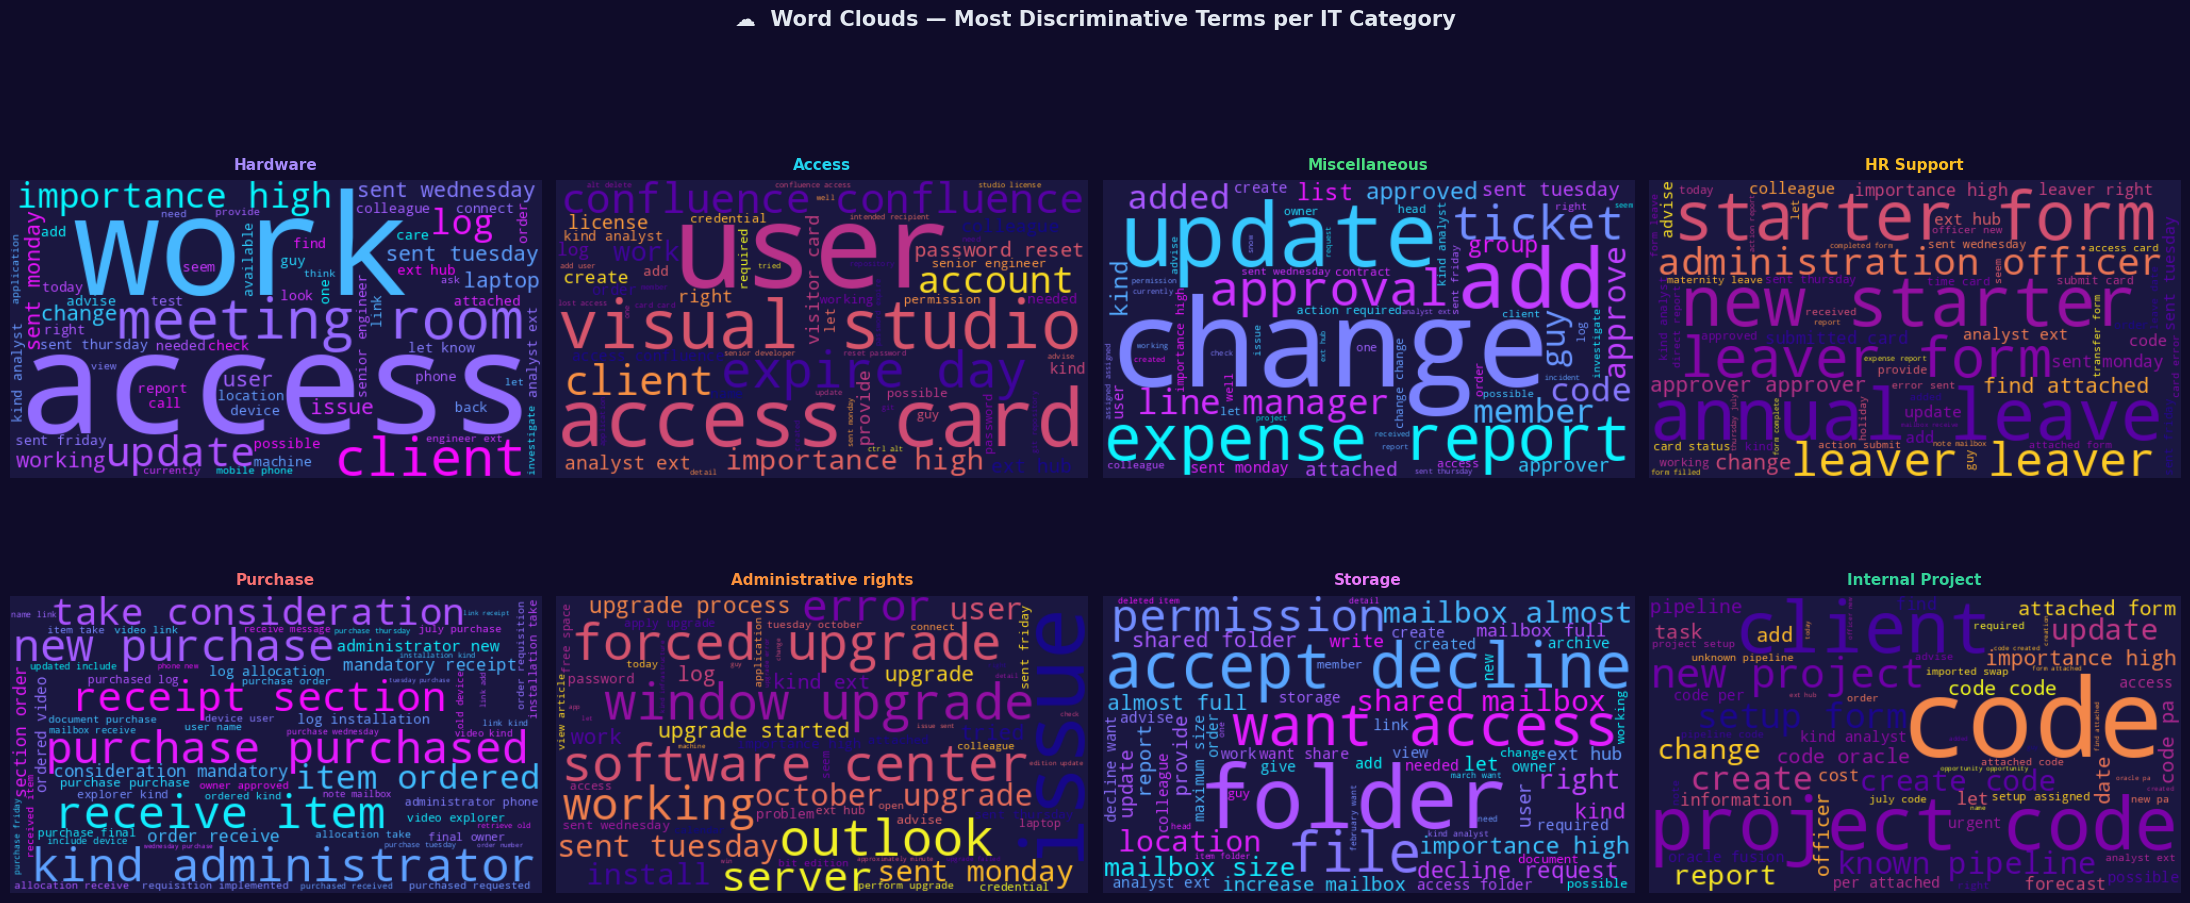

✅  Saved: 02_wordclouds.png


In [10]:
if WC:
    fig, axes = plt.subplots(2, 4, figsize=(22, 10), facecolor=BG)
    fig.suptitle('☁️  Word Clouds — Most Discriminative Terms per IT Category',
                 fontsize=15, fontweight='bold', color=TXT, y=1.01)

    for i, (cat, ax) in enumerate(zip(df_it['Topic_group'].unique(), axes.flatten())):
        corpus = ' '.join(df_it[df_it['Topic_group'] == cat]['clean_text'])
        wc = WordCloud(
            width=500, height=280,
            background_color=CARD,
            colormap='cool' if i % 2 == 0 else 'plasma',
            max_words=60, prefer_horizontal=0.8,
            contour_width=1, contour_color=PALETTE[i]
        ).generate(corpus)
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(cat, color=PALETTE[i], fontsize=11, fontweight='bold', pad=8)
        ax.set_facecolor(BG)

    plt.tight_layout()
    plt.savefig('02_wordclouds.png', dpi=150, bbox_inches='tight', facecolor=BG)
    plt.show()
    print('✅  Saved: 02_wordclouds.png')
else:
    print('⚠️  WordCloud not installed. Run: !pip install wordcloud')

Step 7 — Model Training: IT Ticket Category Classification


In [11]:
# Label encode
le_it = LabelEncoder()
y_it  = le_it.fit_transform(df_it['Topic_group'])

print(f'Classes ({len(le_it.classes_)}): {list(le_it.classes_)}')
print(f'Samples: {len(y_it):,}  |  Test split: 20% = {int(len(y_it)*0.2):,}')

# Stratified split
X_it_tr, X_it_te, y_it_tr, y_it_te = train_test_split(
    df_it['clean_text'], y_it,
    test_size=0.2, random_state=42, stratify=y_it
)

# TF-IDF: unigrams + bigrams + trigrams
tfidf_it = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 3),
    sublinear_tf=True,
    min_df=3,
    analyzer='word'
)
Xv_it_tr = tfidf_it.fit_transform(X_it_tr)
Xv_it_te = tfidf_it.transform(X_it_te)
print(f'\nTF-IDF matrix — Train: {Xv_it_tr.shape}  |  Test: {Xv_it_te.shape}')

# Train 4 models
IT_MODELS = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, C=5.0, solver='saga',
        class_weight='balanced', random_state=42
    ),
    'Linear SVM': LinearSVC(
        max_iter=2000, C=1.0,
        class_weight='balanced', random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=None,
        class_weight='balanced', random_state=42, n_jobs=-1
    ),
    'Naive Bayes': MultinomialNB(alpha=0.05),
}

print('\n🚀 Training models...')
print(f'{"Model":<25}  {"Accuracy":>10}  {"Precision":>10}  {"Recall":>9}  {"F1 (W)":>9}')
print('─'*70)

it_results = {}
for name, model in IT_MODELS.items():
    model.fit(Xv_it_tr, y_it_tr)
    preds = model.predict(Xv_it_te)
    it_results[name] = {
        'model': model, 'preds': preds,
        'acc': accuracy_score(y_it_te, preds),
        'f1':  f1_score(y_it_te, preds, average='weighted'),
        'pre': precision_score(y_it_te, preds, average='weighted'),
        'rec': recall_score(y_it_te, preds, average='weighted'),
    }
    r = it_results[name]
    print(f'{name:<25}  {r["acc"]:>10.4f}  {r["pre"]:>10.4f}  {r["rec"]:>9.4f}  {r["f1"]:>9.4f}')

best_it = max(it_results, key=lambda k: it_results[k]['f1'])
print(f'\n🏆 Best IT Model: {best_it}  →  F1 = {it_results[best_it]["f1"]:.4f}')

Classes (8): ['Access', 'Administrative rights', 'HR Support', 'Hardware', 'Internal Project', 'Miscellaneous', 'Purchase', 'Storage']
Samples: 47,821  |  Test split: 20% = 9,564

TF-IDF matrix — Train: (38256, 15000)  |  Test: (9565, 15000)

🚀 Training models...
Model                        Accuracy   Precision     Recall     F1 (W)
──────────────────────────────────────────────────────────────────────
Logistic Regression            0.8443      0.8472     0.8443     0.8447
Linear SVM                     0.8433      0.8441     0.8433     0.8433
Random Forest                  0.8372      0.8405     0.8372     0.8372
Naive Bayes                    0.7734      0.7877     0.7734     0.7728

🏆 Best IT Model: Logistic Regression  →  F1 = 0.8447


Step 8 — Model Training: Customer Ticket Priority Prediction

In [12]:
from scipy.sparse import hstack, csr_matrix

# Encode priority
le_pri = LabelEncoder()
y_pri  = le_pri.fit_transform(df_cs_model['priority_3'])
print(f'Priority classes: {list(le_pri.classes_)}')
print(f'Distribution: {dict(zip(le_pri.classes_, np.bincount(y_pri)))}')

# TF-IDF on description
tfidf_cs = TfidfVectorizer(
    max_features=8000, ngram_range=(1, 2),
    sublinear_tf=True, min_df=2
)
X_tfidf = tfidf_cs.fit_transform(df_cs_model['clean_text'])

# One-hot encode metadata
meta_cols = ['Ticket Type', 'Ticket Subject', 'Ticket Channel', 'Product Purchased']
X_meta    = csr_matrix(pd.get_dummies(
    df_cs_model[meta_cols], drop_first=False
).values.astype(float))

# Combined feature matrix
X_combined = hstack([X_tfidf, X_meta])
print(f'\nCombined feature matrix: {X_combined.shape}')
print(f'  TF-IDF features : {X_tfidf.shape[1]}')
print(f'  Metadata features: {X_meta.shape[1]}')

# Stratified split
X_pri_tr, X_pri_te, y_pri_tr, y_pri_te = train_test_split(
    X_combined, y_pri, test_size=0.2, random_state=42, stratify=y_pri
)

CS_MODELS = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, C=5.0, class_weight='balanced', random_state=42
    ),
    'Linear SVM': LinearSVC(
        max_iter=2000, C=1.0, class_weight='balanced', random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1
    ),
    'Naive Bayes': MultinomialNB(alpha=0.1),
}

print('\n🚀 Training Priority models (TF-IDF + Metadata)...')
print(f'{"Model":<25}  {"Accuracy":>10}  {"F1 (W)":>9}')
print('─'*50)

pri_results = {}
for name, model in CS_MODELS.items():
    model.fit(X_pri_tr, y_pri_tr)
    preds = model.predict(X_pri_te)
    pri_results[name] = {
        'model': model, 'preds': preds,
        'acc': accuracy_score(y_pri_te, preds),
        'f1':  f1_score(y_pri_te, preds, average='weighted'),
    }
    r = pri_results[name]
    print(f'{name:<25}  {r["acc"]:>10.4f}  {r["f1"]:>9.4f}')

best_pri = max(pri_results, key=lambda k: pri_results[k]['f1'])
print(f'\n🏆 Best Priority Model: {best_pri}  →  F1 = {pri_results[best_pri]["f1"]:.4f}')

Priority classes: ['High', 'Low', 'Medium']
Distribution: {'High': np.int64(4214), 'Low': np.int64(2063), 'Medium': np.int64(2192)}

Combined feature matrix: (8469, 8067)
  TF-IDF features : 8000
  Metadata features: 67

🚀 Training Priority models (TF-IDF + Metadata)...
Model                        Accuracy     F1 (W)
──────────────────────────────────────────────────
Logistic Regression            0.3442     0.3498
Linear SVM                     0.3654     0.3619
Random Forest                  0.4699     0.3602
Naive Bayes                    0.4150     0.3675

🏆 Best Priority Model: Naive Bayes  →  F1 = 0.3675


 Step 9 — Evaluation: Classification Reports & Confusion Matrices

In [13]:
print('═'*65)
print(f'  IT TICKET CATEGORY CLASSIFICATION  ←  {best_it}')
print('═'*65)
print(classification_report(
    y_it_te, it_results[best_it]['preds'],
    target_names=le_it.classes_
))

print('═'*65)
print(f'  CUSTOMER TICKET PRIORITY PREDICTION  ←  {best_pri}')
print('═'*65)
print(classification_report(
    y_pri_te, pri_results[best_pri]['preds'],
    target_names=le_pri.classes_
))

═════════════════════════════════════════════════════════════════
  IT TICKET CATEGORY CLASSIFICATION  ←  Logistic Regression
═════════════════════════════════════════════════════════════════
                       precision    recall  f1-score   support

               Access       0.89      0.90      0.89      1425
Administrative rights       0.64      0.84      0.73       352
           HR Support       0.87      0.84      0.85      2183
             Hardware       0.85      0.79      0.82      2721
     Internal Project       0.80      0.91      0.85       424
        Miscellaneous       0.81      0.84      0.82      1412
             Purchase       0.92      0.90      0.91       493
              Storage       0.86      0.90      0.88       555

             accuracy                           0.84      9565
            macro avg       0.83      0.86      0.84      9565
         weighted avg       0.85      0.84      0.84      9565

═════════════════════════════════════════════════

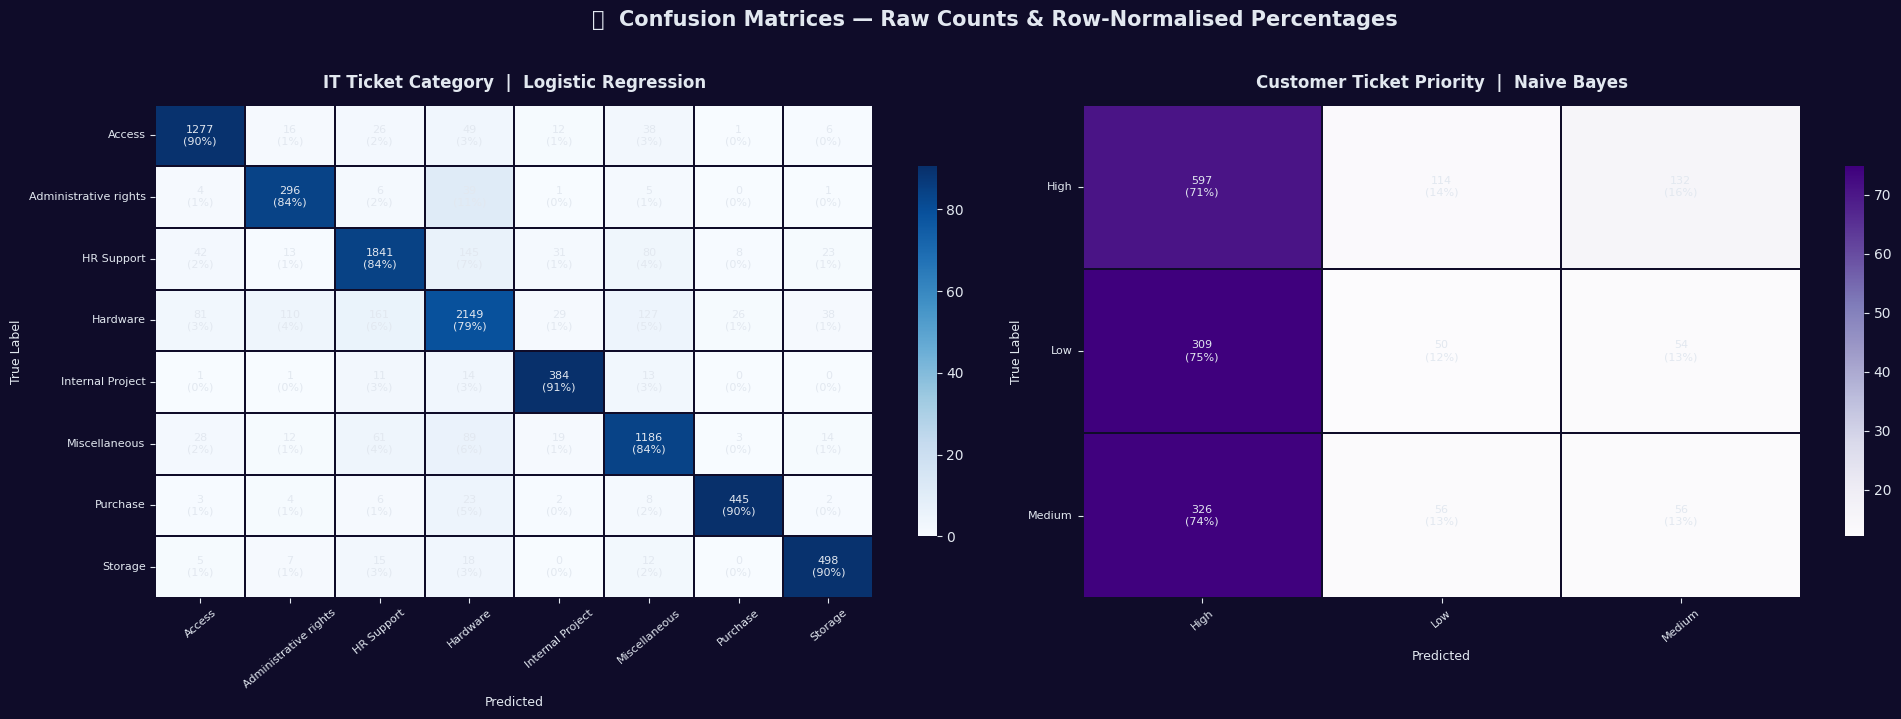

✅  Saved: 03_confusion_matrices.png


In [14]:
def styled_cm(y_true, y_pred, labels, title, ax, cmap='Blues'):
    cm     = confusion_matrix(y_true, y_pred)
    cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
    annot  = np.array([[f'{cm[i,j]}\n({cm_pct[i,j]:.0f}%)'
                        for j in range(cm.shape[1])]
                       for i in range(cm.shape[0])])
    sns.heatmap(cm_pct, annot=annot, fmt='', cmap=cmap,
                xticklabels=labels, yticklabels=labels,
                linewidths=1.2, linecolor=BG, ax=ax,
                cbar_kws={'shrink': 0.75},
                annot_kws={'size': 8, 'color': TXT})
    ax.set_title(title, pad=12)
    ax.set_xlabel('Predicted', fontsize=9)
    ax.set_ylabel('True Label', fontsize=9)
    ax.tick_params(axis='x', rotation=40, labelsize=8)
    ax.tick_params(axis='y', rotation=0,  labelsize=8)


fig, axes = plt.subplots(1, 2, figsize=(20, 7), facecolor=BG)
fig.suptitle('🎯  Confusion Matrices — Raw Counts & Row-Normalised Percentages',
             fontsize=15, fontweight='bold', color=TXT, y=1.02)

styled_cm(
    y_it_te, it_results[best_it]['preds'],
    le_it.classes_,
    f'IT Ticket Category  |  {best_it}',
    axes[0], 'Blues'
)
styled_cm(
    y_pri_te, pri_results[best_pri]['preds'],
    le_pri.classes_,
    f'Customer Ticket Priority  |  {best_pri}',
    axes[1], 'Purples'
)

plt.tight_layout()
plt.savefig('03_confusion_matrices.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()
print('✅  Saved: 03_confusion_matrices.png')

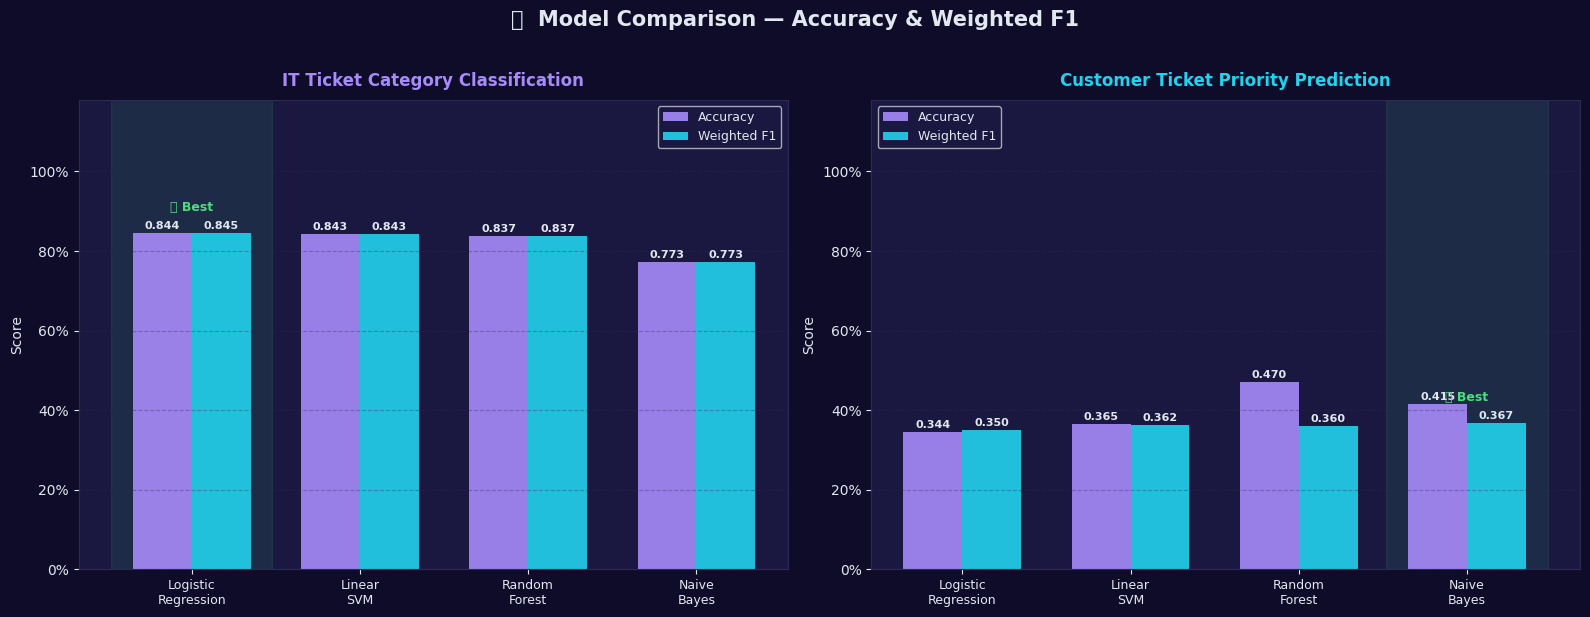

✅  Saved: 04_model_comparison.png


In [15]:
# Model Comparison Chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor=BG)
fig.suptitle('🏆  Model Comparison — Accuracy & Weighted F1',
             fontsize=15, fontweight='bold', color=TXT, y=1.02)

for ax, results, title, accent in [
    (axes[0], it_results,  'IT Ticket Category Classification', A1),
    (axes[1], pri_results, 'Customer Ticket Priority Prediction', A2),
]:
    names = list(results.keys())
    accs  = [results[n]['acc'] for n in names]
    f1s   = [results[n]['f1']  for n in names]
    x, w  = np.arange(len(names)), 0.35

    b1 = ax.bar(x - w/2, accs, w, color=A1, alpha=0.9, label='Accuracy',    edgecolor='none')
    b2 = ax.bar(x + w/2, f1s,  w, color=A2, alpha=0.9, label='Weighted F1', edgecolor='none')

    for bar in list(b1) + list(b2):
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.005,
                f'{h:.3f}', ha='center', va='bottom', fontsize=8,
                fontweight='bold', color=TXT)

    best_idx = int(np.argmax(f1s))
    ax.axvspan(best_idx - 0.48, best_idx + 0.48, alpha=0.10, color=A3, zorder=0)
    ax.text(best_idx, max(f1s) + 0.055, '🏆 Best', ha='center',
            fontsize=9, color=A3, fontweight='bold')

    ax.set_title(title, color=accent, pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels([n.replace(' ', '\n') for n in names], fontsize=9)
    ax.set_ylim(0, 1.18)
    ax.set_ylabel('Score')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.35)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f'{v:.0%}'))

plt.tight_layout()
plt.savefig('04_model_comparison.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()
print('✅  Saved: 04_model_comparison.png')

Step 9b — Cross-Validation (Robustness Check)

🔁 5-Fold Stratified Cross-Validation — Logistic Regression

  IT Category   CV F1: 0.8466 ± 0.0017
                Folds: ['0.847', '0.847', '0.849', '0.844', '0.846']

  CS Priority   CV F1: 0.3633 ± 0.0110
                Folds: ['0.361', '0.360', '0.362', '0.350', '0.384']


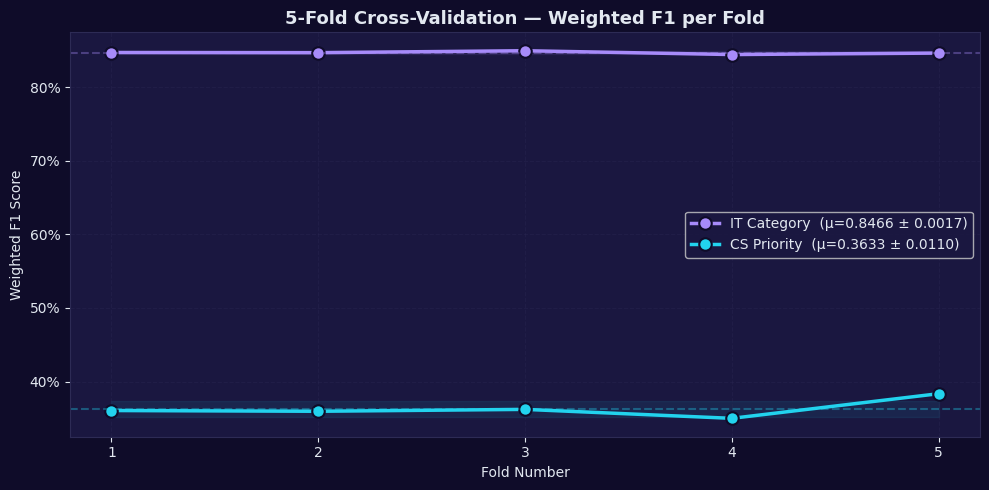

✅  Saved: 05_cross_validation.png


In [16]:
print('🔁 5-Fold Stratified Cross-Validation — Logistic Regression\n')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_records = {}

# IT Category
pipe_it = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2),
                              sublinear_tf=True, min_df=2)),
    ('clf',   LogisticRegression(max_iter=1000, C=5.0,
                                 class_weight='balanced', random_state=42))
])
scores_it = cross_val_score(pipe_it, df_it['clean_text'], y_it,
                            cv=skf, scoring='f1_weighted', n_jobs=-1)
cv_records['IT Category'] = scores_it
print(f'  IT Category   CV F1: {scores_it.mean():.4f} ± {scores_it.std():.4f}')
print(f'                Folds: {[f"{s:.3f}" for s in scores_it]}')

# CS Priority (text only for cross-val)
pipe_pri = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=8000, ngram_range=(1,2),
                              sublinear_tf=True, min_df=2)),
    ('clf',   LogisticRegression(max_iter=1000, C=5.0,
                                 class_weight='balanced', random_state=42))
])
scores_pri = cross_val_score(pipe_pri, df_cs_model['clean_text'], y_pri,
                             cv=skf, scoring='f1_weighted', n_jobs=-1)
cv_records['CS Priority'] = scores_pri
print(f'\n  CS Priority   CV F1: {scores_pri.mean():.4f} ± {scores_pri.std():.4f}')
print(f'                Folds: {[f"{s:.3f}" for s in scores_pri]}')

# CV line chart
fig, ax = plt.subplots(figsize=(10, 5), facecolor=BG)
colors_cv = [A1, A2]
for (task, scores), color in zip(cv_records.items(), colors_cv):
    ax.plot(range(1, 6), scores, marker='o', color=color, linewidth=2.5,
            markersize=9, label=f'{task}  (μ={scores.mean():.4f} ± {scores.std():.4f})',
            markeredgecolor=BG, markeredgewidth=1.5)
    ax.axhline(scores.mean(), color=color, linestyle='--', alpha=0.35, linewidth=1.5)
    ax.fill_between(range(1, 6),
                    scores.mean() - scores.std(),
                    scores.mean() + scores.std(),
                    color=color, alpha=0.08)

ax.set_title('5-Fold Cross-Validation — Weighted F1 per Fold', fontsize=13)
ax.set_xlabel('Fold Number')
ax.set_ylabel('Weighted F1 Score')
ax.set_xticks(range(1, 6))
ax.legend(fontsize=10)
ax.grid(alpha=0.35)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f'{v:.0%}'))

plt.tight_layout()
plt.savefig('05_cross_validation.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()
print('✅  Saved: 05_cross_validation.png')

Step 10 — Feature Importance: What Words Drive Predictions?

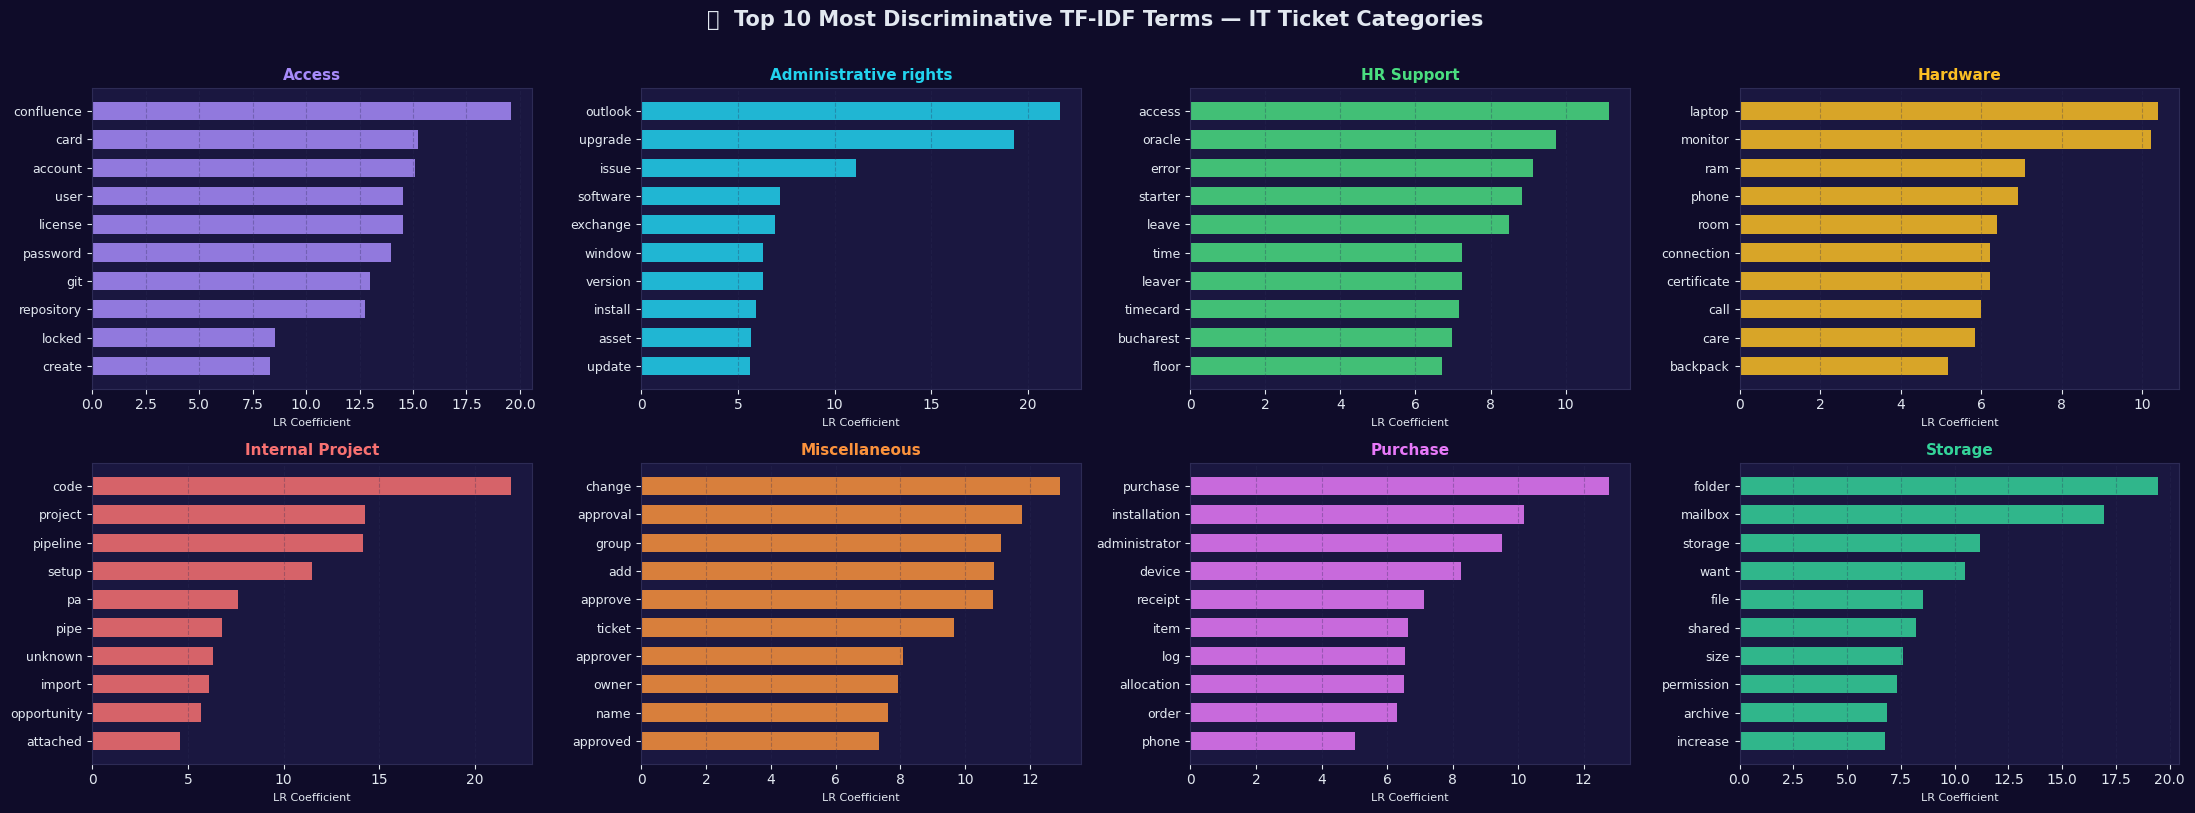

✅  Saved: 06_feature_importance.png


In [17]:
# Use Logistic Regression (always has coef_)
lr_it  = it_results['Logistic Regression']['model']
ft_it  = tfidf_it.get_feature_names_out()
cats   = le_it.classes_
n_cats = len(cats)

TOP_N = 10
cols  = 4
rows  = (n_cats + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*5.5, rows*4), facecolor=BG)
axes      = np.array(axes).flatten()
fig.suptitle(f'🔑  Top {TOP_N} Most Discriminative TF-IDF Terms — IT Ticket Categories',
             fontsize=15, fontweight='bold', color=TXT, y=1.01)

for i, (cat, ax) in enumerate(zip(cats, axes)):
    coefs    = lr_it.coef_[i]
    top_idx  = np.argsort(coefs)[-TOP_N:][::-1]
    terms    = [ft_it[j] for j in top_idx]
    vals     = coefs[top_idx]
    color    = PALETTE[i % len(PALETTE)]

    ax.barh(range(TOP_N), vals[::-1], color=color, alpha=0.85,
            edgecolor='none', height=0.65)
    ax.set_yticks(range(TOP_N))
    ax.set_yticklabels(terms[::-1], fontsize=9)
    ax.set_title(cat, color=color, fontsize=11, fontweight='bold')
    ax.set_xlabel('LR Coefficient', fontsize=8)
    ax.grid(axis='x', alpha=0.3)

for ax in axes[n_cats:]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig('06_feature_importance.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()
print('✅  Saved: 06_feature_importance.png')

Step 11 — Live Inference: Classify Any Ticket Instantly

In [18]:
PRIORITY_BADGE = {'High': '🔴 HIGH', 'Medium': '🟡 MEDIUM', 'Low': '🟢 LOW'}
CAT_ICON = {
    'Hardware': '🖥️', 'HR Support': '👥', 'Access': '🔑',
    'Miscellaneous': '📦', 'Storage': '💾', 'Purchase': '🛒',
    'Internal Project': '📁', 'Administrative rights': '⚙️',
}


def classify_it_ticket(raw_text: str) -> dict:
    """Classify an IT service ticket into one of 8 categories."""
    cleaned  = clean_text(raw_text)
    features = tfidf_it.transform([cleaned])
    pred_idx = it_results[best_it]['model'].predict(features)[0]
    category = le_it.inverse_transform([pred_idx])[0]

    # Confidence (LR only)
    conf = 'N/A'
    if hasattr(it_results[best_it]['model'], 'predict_proba'):
        proba = it_results[best_it]['model'].predict_proba(features)[0]
        conf  = f'{proba.max():.1%}'
        top3  = [(le_it.classes_[j], f'{proba[j]:.1%}')
                 for j in np.argsort(proba)[::-1][:3]]
    else:
        top3 = [(category, conf)]

    return {'type': 'IT', 'category': category, 'confidence': conf, 'top3': top3}


def classify_cs_priority(raw_text: str,
                          ticket_type: str = 'Technical issue',
                          ticket_subject: str = 'Hardware issue',
                          channel: str = 'Email',
                          product: str = 'Dell XPS') -> dict:
    """Predict priority (High/Medium/Low) for a customer support ticket."""
    from scipy.sparse import hstack, csr_matrix

    cleaned  = clean_text(raw_text)
    tfidf_f  = tfidf_cs.transform([cleaned])

    # Build metadata feature row
    meta_row = pd.DataFrame([{
        'Ticket Type': ticket_type,
        'Ticket Subject': ticket_subject,
        'Ticket Channel': channel,
        'Product Purchased': product,
    }])
    meta_enc  = pd.get_dummies(meta_row)
    # Align columns to training columns
    train_meta_cols = pd.get_dummies(
        df_cs_model[['Ticket Type','Ticket Subject','Ticket Channel','Product Purchased']],
        drop_first=False
    ).columns
    meta_enc  = meta_enc.reindex(columns=train_meta_cols, fill_value=0)
    meta_f    = csr_matrix(meta_enc.values.astype(float))

    features  = hstack([tfidf_f, meta_f])
    pred_idx  = pri_results[best_pri]['model'].predict(features)[0]
    priority  = le_pri.inverse_transform([pred_idx])[0]

    conf = 'N/A'
    if hasattr(pri_results[best_pri]['model'], 'predict_proba'):
        conf = f"{pri_results[best_pri]['model'].predict_proba(features)[0].max():.1%}"

    return {'type': 'CS', 'priority': priority, 'badge': PRIORITY_BADGE[priority],
            'confidence': conf}


# Demo
demos = [
    ('IT', "My laptop keyboard stopped working after the Windows update yesterday.", {}),
    ('IT', "Please grant admin access to the finance team shared drive folder.", {}),
    ('IT', "Need to request 2TB additional storage for the marketing department.", {}),
    ('IT', "New employee Sarah joining Monday needs badge access to 3rd floor lab.", {}),
    ('CS', "My account was charged twice and I need an immediate refund.",
           {'ticket_type':'Billing inquiry','ticket_subject':'Payment issue',
            'channel':'Chat','product':'Apple AirPods'}),
    ('CS', "Can you tell me what subscription plans you offer for teams?",
           {'ticket_type':'Product inquiry','ticket_subject':'Product recommendation',
            'channel':'Email','product':'Sony Xperia'}),
]

print('━'*70)
print('  🎯  LIVE INFERENCE DEMO')
print('━'*70)

for ds, text, kwargs in demos:
    snippet = text[:65] + '...' if len(text) > 65 else text
    print(f'\n📩  "{snippet}"')
    if ds == 'IT':
        r   = classify_it_ticket(text)
        ico = CAT_ICON.get(r['category'], '🎫')
        print(f'    Dataset  : IT Service Ticket')
        print(f'    Category : {ico}  {r["category"]}  (confidence: {r["confidence"]})')
        if r['top3'][0][1] != 'N/A':
            print(f'    Top-3    : ' + ' | '.join(f'{c} ({p})' for c, p in r['top3']))
    else:
        r = classify_cs_priority(text, **kwargs)
        print(f'    Dataset  : Customer Support Ticket')
        print(f'    Priority : {r["badge"]}  (confidence: {r["confidence"]})')
    print('    ' + '─'*60)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  🎯  LIVE INFERENCE DEMO
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📩  "My laptop keyboard stopped working after the Windows update yeste..."
    Dataset  : IT Service Ticket
    Category : 🖥️  Hardware  (confidence: 84.4%)
    Top-3    : Hardware (84.4%) | Administrative rights (15.3%) | Access (0.1%)
    ────────────────────────────────────────────────────────────

📩  "Please grant admin access to the finance team shared drive folder..."
    Dataset  : IT Service Ticket
    Category : 💾  Storage  (confidence: 100.0%)
    Top-3    : Storage (100.0%) | HR Support (0.0%) | Hardware (0.0%)
    ────────────────────────────────────────────────────────────

📩  "Need to request 2TB additional storage for the marketing departme..."
    Dataset  : IT Service Ticket
    Category : 💾  Storage  (confidence: 94.9%)
    Top-3    : Storage (94.9%) | HR Support (2.2%) | Access (1.2%)
    ──────────────

Step 12 — Executive Dashboard

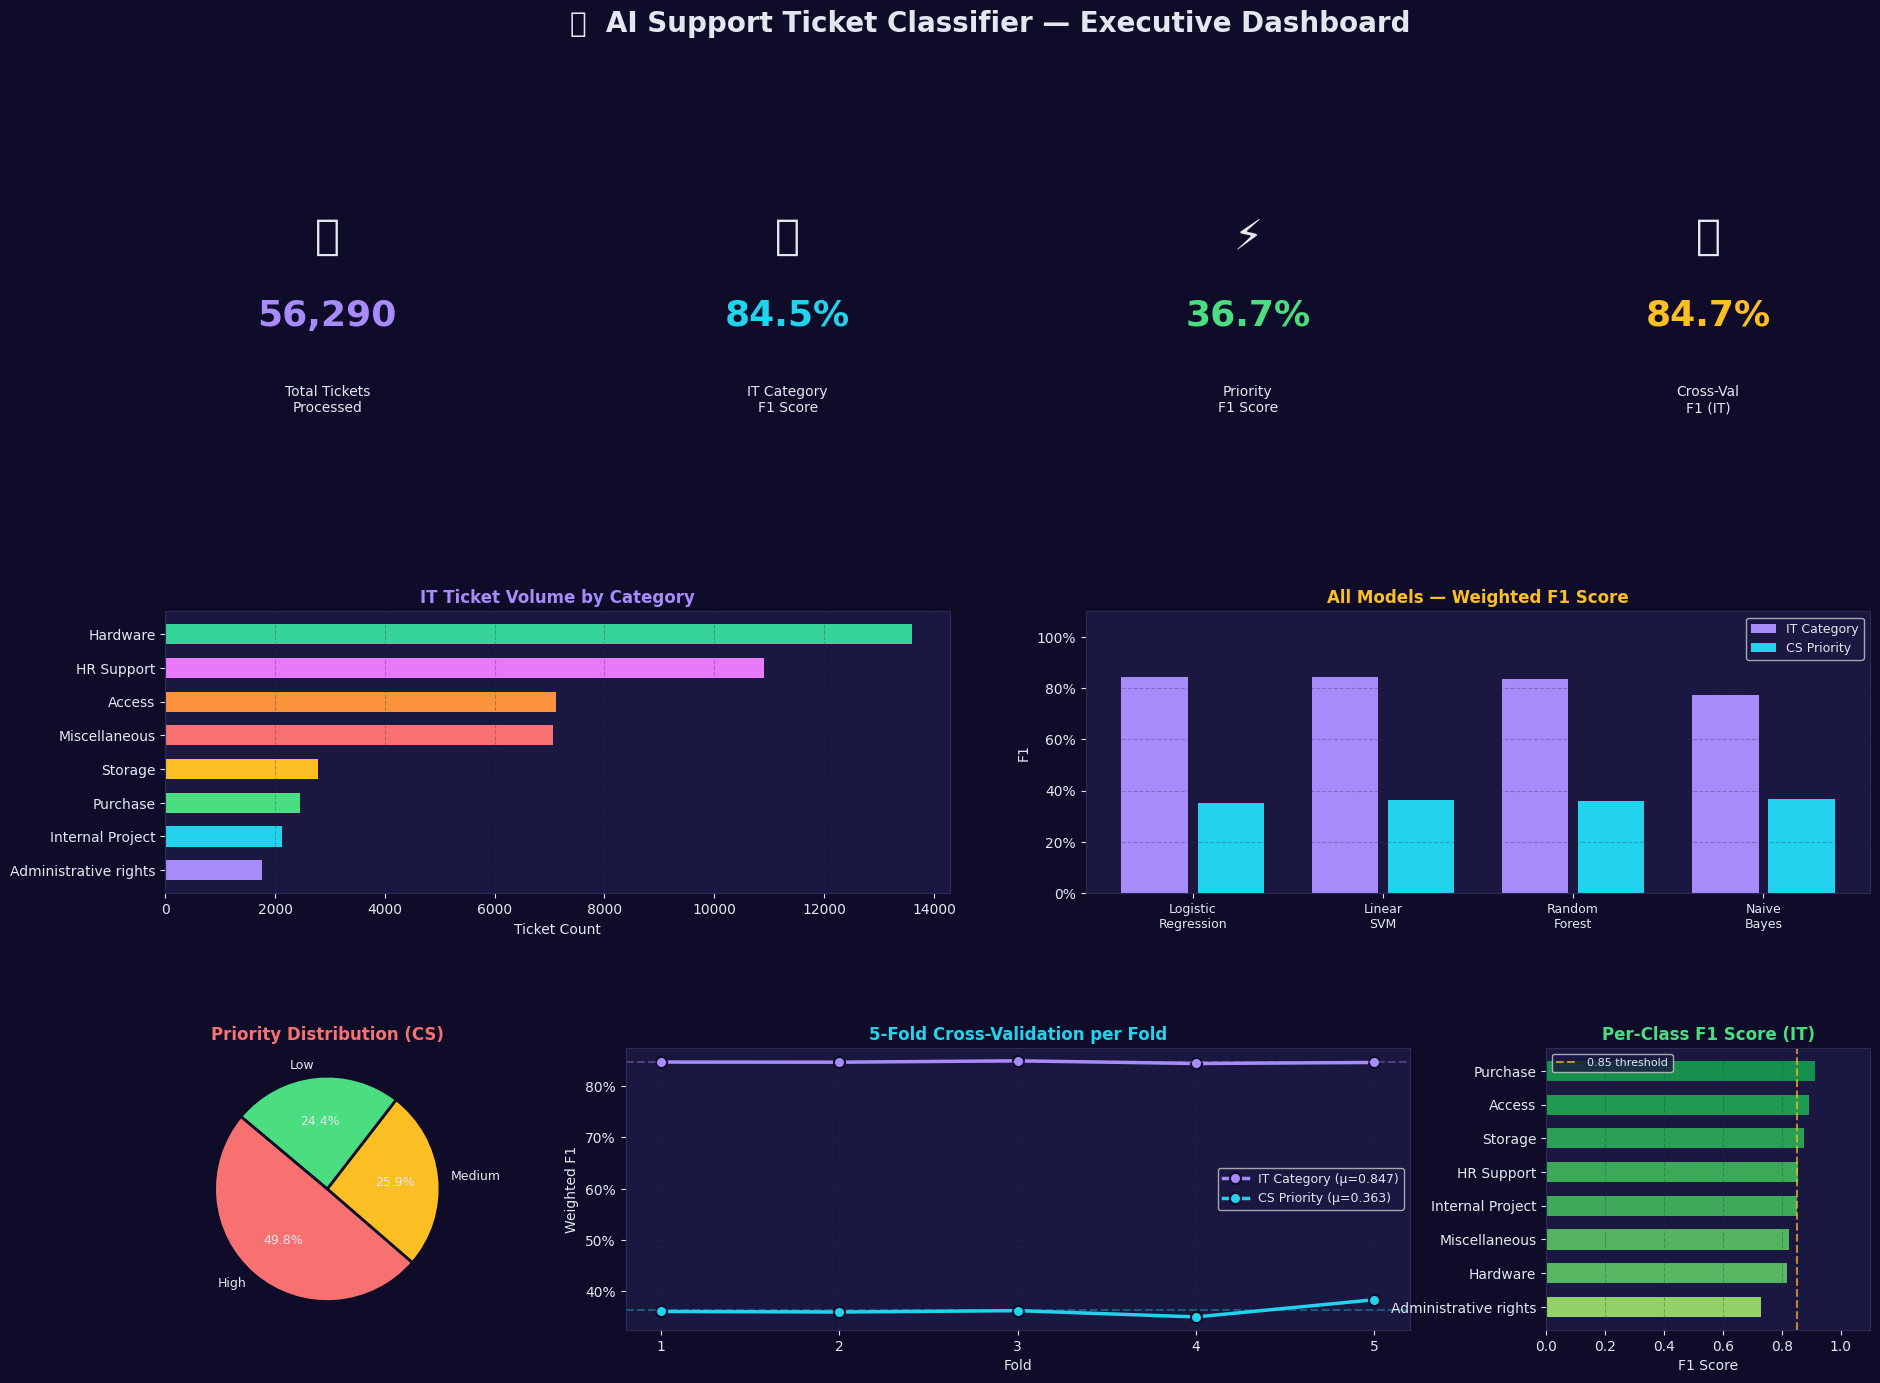

✅  Saved: 07_executive_dashboard.png


In [19]:
fig = plt.figure(figsize=(22, 15), facecolor=BG)
fig.suptitle('🎫  AI Support Ticket Classifier — Executive Dashboard',
             fontsize=20, fontweight='bold', color=TXT, y=0.99)

gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.55, wspace=0.42)

# KPI Cards
kpi_items = [
    ('Total Tickets\nProcessed', f"{len(df_it)+len(df_cs_model):,}", A1, '📊'),
    ('IT Category\nF1 Score',   f"{it_results[best_it]['f1']:.1%}",  A2, '🏷️'),
    ('Priority\nF1 Score',      f"{pri_results[best_pri]['f1']:.1%}",A3, '⚡'),
    ('Cross-Val\nF1 (IT)',      f"{cv_records['IT Category'].mean():.1%}", A4, '🔁'),
]
for i, (label, value, color, emoji) in enumerate(kpi_items):
    ax = fig.add_subplot(gs[0, i])
    ax.set_facecolor(CARD)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.axis('off')
    for spine_name, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color(color)
        spine.set_linewidth(2.5)
    ax.text(0.5, 0.78, emoji,  ha='center', va='center', fontsize=30)
    ax.text(0.5, 0.50, value,  ha='center', va='center',
            fontsize=26, fontweight='bold', color=color)
    ax.text(0.5, 0.20, label,  ha='center', va='center',
            fontsize=10, color=TXT, multialignment='center')

# IT Category bar
ax_it = fig.add_subplot(gs[1, :2])
it_vc = df_it['Topic_group'].value_counts()
ax_it.barh(it_vc.index[::-1], it_vc.values[::-1],
           color=PALETTE[:len(it_vc)], height=0.6, edgecolor='none')
ax_it.set_title('IT Ticket Volume by Category', color=A1)
ax_it.set_xlabel('Ticket Count')
ax_it.grid(axis='x', alpha=0.3)

# All-model F1 comparison
ax_f1 = fig.add_subplot(gs[1, 2:])
model_names = list(IT_MODELS.keys())
it_f1s  = [it_results[m]['f1']  for m in model_names]
pri_f1s = [pri_results[m]['f1'] for m in model_names]
x = np.arange(len(model_names))
ax_f1.bar(x - 0.2, it_f1s,  0.35, color=A1, label='IT Category',  edgecolor='none')
ax_f1.bar(x + 0.2, pri_f1s, 0.35, color=A2, label='CS Priority',  edgecolor='none')
ax_f1.set_xticks(x)
ax_f1.set_xticklabels([m.replace(' ','\n') for m in model_names], fontsize=9)
ax_f1.set_title('All Models — Weighted F1 Score', color=A4)
ax_f1.set_ylabel('F1')
ax_f1.set_ylim(0, 1.1)
ax_f1.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,_: f'{v:.0%}'))
ax_f1.legend(fontsize=9)
ax_f1.grid(axis='y', alpha=0.3)

# Priority distribution pie
ax_pie = fig.add_subplot(gs[2, 0])
pri_vc2 = df_cs_model['priority_3'].value_counts().reindex(['High','Medium','Low'])
ax_pie.pie(pri_vc2, labels=pri_vc2.index, autopct='%1.1f%%',
           colors=[A5, A4, A3], startangle=140,
           wedgeprops={'edgecolor': BG, 'linewidth': 2},
           textprops={'color': TXT, 'fontsize': 9})
ax_pie.set_title('Priority Distribution (CS)', color=A5)
ax_pie.set_facecolor(BG)

# CV line chart
ax_cv = fig.add_subplot(gs[2, 1:3])
for (task, scores), col in zip(cv_records.items(), [A1, A2]):
    ax_cv.plot(range(1,6), scores, marker='o', color=col, linewidth=2.5,
               markersize=8, label=f'{task} (μ={scores.mean():.3f})',
               markeredgecolor=BG, markeredgewidth=1.5)
    ax_cv.axhline(scores.mean(), color=col, linestyle='--', alpha=0.35)
ax_cv.set_title('5-Fold Cross-Validation per Fold', color=A2)
ax_cv.set_xlabel('Fold'); ax_cv.set_ylabel('Weighted F1')
ax_cv.set_xticks(range(1,6))
ax_cv.legend(fontsize=9)
ax_cv.grid(alpha=0.3)
ax_cv.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,_: f'{v:.0%}'))

# Per-class F1 heatmap
ax_hm = fig.add_subplot(gs[2, 3])
report = classification_report(
    y_it_te, it_results[best_it]['preds'],
    target_names=le_it.classes_, output_dict=True
)
class_f1 = {k: report[k]['f1-score']
            for k in le_it.classes_}
classes_sorted = sorted(class_f1, key=class_f1.get, reverse=True)
vals = [class_f1[c] for c in classes_sorted]
cmap_hm = plt.cm.RdYlGn
colors_hm = [cmap_hm(v) for v in vals]
ax_hm.barh(classes_sorted[::-1], vals[::-1], color=colors_hm[::-1],
           height=0.6, edgecolor='none')
ax_hm.axvline(0.85, color=A4, linestyle='--', alpha=0.7, label='0.85 threshold')
ax_hm.set_xlim(0, 1.1)
ax_hm.set_title('Per-Class F1 Score (IT)', color=A3)
ax_hm.set_xlabel('F1 Score')
ax_hm.legend(fontsize=8)
ax_hm.grid(axis='x', alpha=0.3)

plt.savefig('07_executive_dashboard.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()
print('✅  Saved: 07_executive_dashboard.png')

Step 13 — Save Models & Download All Outputs

In [20]:
os.makedirs('saved_models', exist_ok=True)

artifacts = {
    'saved_models/tfidf_it.pkl':       tfidf_it,
    'saved_models/tfidf_cs.pkl':       tfidf_cs,
    'saved_models/model_it_cat.pkl':   it_results[best_it]['model'],
    'saved_models/model_cs_pri.pkl':   pri_results[best_pri]['model'],
    'saved_models/le_it.pkl':          le_it,
    'saved_models/le_pri.pkl':         le_pri,
}
for path, obj in artifacts.items():
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
    print(f'  💾  {path}')

# Metrics summary CSV
rows = []
for name, r in it_results.items():
    rows.append({'Task':'IT Category','Model':name,
                 'Accuracy':f"{r['acc']:.4f}", 'Weighted_F1':f"{r['f1']:.4f}"})
for name, r in pri_results.items():
    rows.append({'Task':'CS Priority','Model':name,
                 'Accuracy':f"{r['acc']:.4f}", 'Weighted_F1':f"{r['f1']:.4f}"})
metrics_df = pd.DataFrame(rows)
metrics_df.to_csv('model_metrics.csv', index=False)
print(f'\n📋 Model Metrics:\n{metrics_df.to_string(index=False)}')

# Zip all outputs
output_files = [
    'model_metrics.csv',
    '01_eda_overview.png', '02_wordclouds.png',
    '03_confusion_matrices.png', '04_model_comparison.png',
    '05_cross_validation.png', '06_feature_importance.png',
    '07_executive_dashboard.png',
] + [f'saved_models/{f}' for f in os.listdir('saved_models')]

with zipfile.ZipFile('ticket_classifier_outputs.zip', 'w') as zf:
    for f in output_files:
        if os.path.exists(f):
            zf.write(f)

print('\n📦  All outputs zipped → ticket_classifier_outputs.zip')
files.download('ticket_classifier_outputs.zip')

  💾  saved_models/tfidf_it.pkl
  💾  saved_models/tfidf_cs.pkl
  💾  saved_models/model_it_cat.pkl
  💾  saved_models/model_cs_pri.pkl
  💾  saved_models/le_it.pkl
  💾  saved_models/le_pri.pkl

📋 Model Metrics:
       Task               Model Accuracy Weighted_F1
IT Category Logistic Regression   0.8443      0.8447
IT Category          Linear SVM   0.8433      0.8433
IT Category       Random Forest   0.8372      0.8372
IT Category         Naive Bayes   0.7734      0.7728
CS Priority Logistic Regression   0.3442      0.3498
CS Priority          Linear SVM   0.3654      0.3619
CS Priority       Random Forest   0.4699      0.3602
CS Priority         Naive Bayes   0.4150      0.3675

📦  All outputs zipped → ticket_classifier_outputs.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>